<a href="https://colab.research.google.com/github/axel-sirota/tf-dev-nlp/blob/main/module3/TF_Developer_NLP_Module3_Demo1_Analysing_Sentiment_With_OHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing Sentiment

## Setup stuff

Let's first import everything and load the dataset

In [1]:
!pip install textblob scikit-learn pandas gensim matplotlib

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/, http://pypi.douban.com/simple, http://pypi.mirrors.ustc.edu.cn/simple/, https://pypi.tuna.tsinghua.edu.cn/simple/


In [2]:
import multiprocessing
import tensorflow as tf
import sys
keras = tf.keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, Input
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.nn import leaky_relu
import numpy as np
import random
import os
import pandas as pd
import gensim
import warnings
import nltk

TRACE = False # To verify where our operations run, you can always set the TRACE variable to True and check it for yourself.

def set_seeds_and_trace():
  """This function sets seeds and traces such that the notebook is reproducible."""
  os.environ['PYTHONHASHSEED'] = '0' # the secret seed Python uses for its own hash function and also must be set for reproducibility.
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  """This function counts the available GPUs and cores and sets them to the Tensorflow and Keras session. By default, TensorFlow will choose to
     allocate all its operations in the accelerated hardware if existent. So this helps you to do that."""
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config) 
  K.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.set_proxy('http://127.0.0.1:51066') # nltk: Natural Language Toolkit，自然语言处理工具包，在NLP领域中，最常使用的一个Python库。
nltk.download('punkt') # 在Windows上，nltk下载后的数据据存放在 $HOME\AppData\Roaming\nltk_data,如C:\Users\longqinsi\AppData\Roaming\nltk_data

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\longqinsi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Now we will download the dataset and explore it

%%writefile get_data.sh
if [ ! -f yelp.csv ]; then
  wget -O yelp.csv https://www.dropbox.com/s/xds4lua69b7okw8/yelp.csv?dl=0
fi

!bash get_data.sh


In [3]:
path = './yelp.csv'
yelp = pd.read_csv(path)
yelp


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,VY_tvNUCCXGXQeSvJl757Q,2012-07-28,Ubyfp2RSDYW0g7Mbr8N3iA,3,First visit...Had lunch here today - used my G...,review,_eqQoPtQ3e3UxLE4faT6ow,1,2,0
9996,EKzMHI1tip8rC1-ZAy64yg,2012-01-18,2XyIOQKbVFb6uXQdJ0RzlQ,4,Should be called house of deliciousness!\n\nI ...,review,ROru4uk5SaYc3rg8IU7SQw,0,0,0
9997,53YGfwmbW73JhFiemNeyzQ,2010-11-16,jyznYkIbpqVmlsZxSDSypA,4,I recently visited Olive and Ivy for business ...,review,gGbN1aKQHMgfQZkqlsuwzg,0,0,0
9998,9SKdOoDHcFoxK5ZtsgHJoA,2012-12-02,5UKq9WQE1qQbJ0DJbc-B6Q,2,My nephew just moved to Scottsdale recently so...,review,0lyVoNazXa20WzUyZPLaQQ,0,0,0


In [4]:
# Create a new DataFrame that only contains the 5-star and 1-star reviews.
yelp_best_worst = yelp[(yelp.stars==5) | (yelp.stars==1)] # filter out all the reviews that aren't very good or very bad to make the problem a lit easier.
# the reviews
X = yelp_best_worst.text
# What we need to predict is the actual stars. However, we will map the 1 star to 0 and 5 stars to 1 such that
# the labels to predict are contiguous(接触的,邻近的), which is a requirement in classification problems. So this
# marks a positive review with a presence in the classification task of predicting sentiment.
y = yelp_best_worst.stars.map({1:0, 5:1})


In this cell, we count the frequency of positives and negatives, and we have more positive reviews,
and <span style="background:yellow">we have move positive reviews than negative reviews, but not too much, so we can work with this.
Also notice that this just on way of doing sentiment analysis. We could have taken the route of predicting a sentiment score as a number
between 0 and 1, but that would be much harder.</span>

In [5]:
y.value_counts()

1    3337
0     749
Name: stars, dtype: int64

Our dataset is not too imbalanced so we can move on!<br>
We need to predict sentiment, for this we need two things - a corpus(语料库) and the vocabulary.

## Filtering and creating the corpus

Our first job is to filter the reviews that are too short or have weird characters. One way is using TextBlob, although we will see others as we progress.

In [6]:
corpus_with_ix = [(ix, ' '.join(TextBlob(sentence).words)) for ix, sentence in X.iteritems() if type(sentence) == str and len(TextBlob(sentence).words) > 3]

In [7]:
corpus_with_ix[0]

(0,
 "My wife took me here on my birthday for breakfast and it was excellent The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning It looked like the place fills up pretty quickly so the earlier you get here the better Do yourself a favor and get their Bloody Mary It was phenomenal and simply the best I 've ever had I 'm pretty sure they only use ingredients from their garden and blend them fresh when you order it It was amazing While EVERYTHING on the menu looks excellent I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete It was the best toast I 've ever had Anyway I ca n't wait to go back")

In [8]:
# In this cell we put this corpus with index and create two columns and
# check the first rows.
corpus_df = pd.DataFrame(corpus_with_ix, columns=['index', 'text'])

In [9]:
corpus_df.head()

,index,text
0,0,My wife took me here on my birthday for breakf...
1,1,I have no idea why some people give bad review...
2,3,Rosie Dakota and I LOVE Chaparral Dog Park It ...
3,4,General Manager Scott Petello is a good egg No...
4,6,Drop what you 're doing and drive here After I...


Notice that the index column is not "the same" as the index of the DF, because some sentences are filtered out. Now we need to filter out the corresponding y values

In [10]:
y_filtered = y[corpus_df['index']].to_numpy()

In [11]:
corpus = [sentence for ix, sentence in corpus_with_ix]

In [12]:
corpus[0]

"My wife took me here on my birthday for breakfast and it was excellent The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning It looked like the place fills up pretty quickly so the earlier you get here the better Do yourself a favor and get their Bloody Mary It was phenomenal and simply the best I 've ever had I 'm pretty sure they only use ingredients from their garden and blend them fresh when you order it It was amazing While EVERYTHING on the menu looks excellent I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete It was the best toast I 've ever had Anyway I ca n't wait to go back"

## The 1st key step: the tokenizer step

Now we will use Keras tokenizer to construct a vocab and a word to index mapping. In further demos we will change these by embeddings.<br>
What we will do is to convert a list of sentences into a list of tokenized reviews, which are nothing more than a list of IDs.

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
tokenized_corpus = tokenizer.texts_to_sequences(corpus) # What this did is basically it went through all the corpus, split into words, generated the vocabulary for those words, and then allocated indices to all those words and then now converts the corpus into a new object where basically it replaces each word by its ID.
tokenized_corpus[0][:6]


[13, 411, 204, 36, 41, 21]

In [14]:
# I sum how many samples and what is the length of this vocabulary.
nb_samples = sum(len(s) for s in corpus)
vocab_size = len(tokenizer.word_index) + 1

In [15]:
# We can see that we have over 19,000 words in our vocabulary and over 2.5 million tokens,
# which we remember, are words.
nb_samples, vocab_size

(2616086, 19331)

Notice we handled 2 million tokens in almost 20K words indexed.
We have done the first step, created the vocabulary and the mapping. That word_index will basically allow us to go from a given word to a given index.<br>
And then we have an inverse mapping with the given index to get the word.<br>
So now we can come and go between words and indices.

## The 2nd critical step: Creating the tensor

Now comes the crucial step, we need to PAD out tokenized corpus to construct the tensor. For this we can verify the value 0 is not used for any word.

![](a-model-is-just-a-function.png)

We need to construct our tensor from the tokenized corpus. At the start, we had our corpus, which was a list of sentences.
However, each sentence has a different number of words. So if our corpus have the above two reviews:
"I loved the ice cream" and "It is not what it used to be", then after the tokenization, it would look like this, where
you would have two columns, one per review, because this is the collapsed representation of the one-hot encoding, where
for each word, the index in the characters to index mapping. So we will have [13,441,54,34,67,73] representing "I loved
the ice cream". However, the second sentence has more words. So, how do we fill this? If we create a NumPy array out of
this tokenized list, it cannot be converted into a TensorFlow tensor. The reason is that TensorFlow tensors needs to have
a defined shape. This means that for each row, the amount of columns is the same. And if we go to higher dimensions, it
would mean that for a row and column, the amount of channels is the same and so on. Therefore, we need to pad our corpus.
This means that we will fill each document with some values to the right of each row, so that all the tokenized reviews
have the same number of columns and rows, which are tokens for us. The key part is that the value that we use does not
map to any word in our vocabulary. Supposing it is 0 like it normally is, the padded corpus would be the like the rightmost
matrix in the above diagram. Notice the 0s at the bottom of the first column. Now this padded tokenized corpus can indeed
be converted into a tensor.

In [16]:
for ix, word in tokenizer.index_word.items():
  print(ix, word)
  if ix > 5:
    break

1 the
2 and
3 i
4 a
5 to
6 of


Notice that it basically goes for each ID a different word, and the id starts on 1, therefore we can pad
our corpus with 0s as expected. So we need to find out what is the review with the most tokens. That is,
what is the width of our tensor.

In [17]:
def get_maximum_review_length(tokenized_corpus):
    maximum = 0
    for sentence in tokenized_corpus:
        candidate = len(sentence)
        if candidate > maximum:
            maximum = candidate
    return maximum
max_review_length = get_maximum_review_length(tokenized_corpus)

In [18]:
max_review_length

933

Next, we construct a NumPy array of the size we want and all 0s. The size we want is the number of reviews as rows
and the number we calculated as columns. Then we need to go review by review, extend the list with the number of 0s
needed to have the length, the number we calculated before. And finally we replace a NumPy array at the corresponding
row by index with the newly calculated padded tokenized review. At the end of that, we could have our NumPy array all
filled with the corresponding word indices. This can later be converted into a TensorFlow tensor easily.

In [19]:
final_X = np.zeros((len(tokenized_corpus), max_review_length))
for ix, tokenized_sentence in enumerate(tokenized_corpus):
    tokenized_sentence.extend([0]*(max_review_length-len(tokenized_sentence)))
    final_X[ix] = tokenized_sentence

Finally, we appended 0s at the end to have a proper matrix. Later we will use keras methods to do this

## Doing the train_test split and defining model

In [20]:
from sklearn.model_selection import train_test_split

# We split the dataset, leave 40% of the data for the test set.
X_train, X_test, y_train, y_test = train_test_split(final_X, y_filtered, test_size = 0.4, random_state=42)

We convert everything to tensor with tf.constant

In [21]:
X_train_tensor = tf.constant(X_train)
X_test_tensor = tf.constant(X_test)
y_train_tensor = tf.constant(y_train)
y_test_tensor = tf.constant(y_test)

Notice the shape of X_train_tensor is [2433, 933]. The number 933 must be the maximum review length.

In [22]:
X_train_tensor.shape

TensorShape([2433, 933])

In [23]:
max_review_length

933

Notice all the work one needs to do to properly pass from a text dataset into a real dataset one can
use as input to neural network. This is the heavy lifting that a lot of people overlook and underestimate.
Our model actually is going to be extremely simple because I don't want to focus on the architecture now,
but in the process, which is what we have done before. We are going to have 2 layers of 150 neurons, and
we end with 1 neuron and a sigmoid because we're predicting 1 number, the probability of being positive.
Later, we will convert this probability into a positive or negative review simply be saying if it's more
than 0.5, then it's positive. Otherwise, it's negative, which states our decision boundary. This kind of
reasoning I hope is not new to you my dear. If it is, then I recommend you taking the following course
afterward: TensorFlow Developer: Image Classification with TensorFlow, which covers that topic extensively.

In [24]:
model = Sequential()
model.add(Input(shape = (max_review_length,)))
model.add(Dense(100, activation=leaky_relu))
model.add(Dense(50, activation=leaky_relu))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               93400     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 98,501
Trainable params: 98,501
Non-trainable params: 0
_________________________________________________________________


Before running the fit method and training the network, sometimes it is good to run a test input to
verify that what our model does look kind of okay in terms of shape and such. For that, we first create
an array of size 1 in rows and the correct number of columns. Then we got the index for the world horrible,
which is 565. And as this review just has this word, this means it corresponds to a position 0, 0 in the text
input. We predicted it, and notice that when we run it, it's just one number between 0 and 1, and actually
it's quite okay because it's 1 times e to the -7, which is very close to zero, so it's very negative, although,
of course, that could have been luck.

In [26]:
test_point = np.zeros((1, max_review_length))
token_horrible = tokenizer.texts_to_sequences(['Horrible'])[0][0]
token_horrible

565

In [27]:
test_point[0,0] = token_horrible
model(tf.constant(test_point))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.4525959e-07]], dtype=float32)>

To train the network, we're going to use a technique called <span style="background:yellow">early stopping</span> for this training and most trainings in this course. The idea of "Early stopping" is quite simple, if your target metric does not improve for a number of epochs, then stop the training because
you have converged(收敛).

![](early-stopping.png)

The idea behind "early stopping" is the following:<br>
<span style="background:yellow">Suppose you don't stop the training and end at the number of epochs you determine at the start, then normally what happens
is the above where the blue line represents the training error and the red line represents the validation error. This is
because, at a glance, the optimizer tries so hard to reduce the target metric that it creates models that only fit the
training set and don't generalize well. The classic image on the decision boundary is the following where the black line
represents the natural decision boundary in a classification problem of distinguishing red and blue like negatives and positives,
and the green line is the classifier of an overfitted method. As you can see, it is nothing like the reality, so it's not
actually useful afterward. <u>Therefore, the idea of early stopping is just to stop before this happens, providing some kind of
protection.</u> These methods that try to overcome these problems are called <b>regularization methods</b>.</span>

![](overfitting.png)

In [28]:
from keras.callbacks import EarlyStopping

# We will use early stopping(提前停止), stating we want to maximize the precision on the validation set
# and if it doesn't get better after five epochs to stop. The way early stopping works in TensorFlow
# is via callbacks, so we provide it to the fit method.
callback = EarlyStopping(monitor='val_precision', patience=5, min_delta=0.01, mode="max")
history = model.fit(X_train_tensor, y_train_tensor, epochs = 30,
                    # TensorFlow internally will split the dataset and use 80% for training and 20% for validation.
                    validation_split=0.2,
                    workers = 5, callbacks=[callback], verbose=1)

Epoch 1/30
61/61 [==============================] - 1s 6ms/step - loss: 140.9445 - accuracy: 0.6953 - precision: 0.8206 - recall: 0.8046 - val_loss: 87.4669 - val_accuracy: 0.7125 - val_precision: 0.8155 - val_recall: 0.8321
Epoch 2/30
61/61 [==============================] - 0s 2ms/step - loss: 29.7978 - accuracy: 0.7960 - precision: 0.8717 - recall: 0.8810 - val_loss: 64.2440 - val_accuracy: 0.6345 - val_precision: 0.8028 - val_recall: 0.7252
Epoch 3/30
61/61 [==============================] - 0s 2ms/step - loss: 11.7439 - accuracy: 0.8489 - precision: 0.9105 - recall: 0.9048 - val_loss: 61.7645 - val_accuracy: 0.6838 - val_precision: 0.8072 - val_recall: 0.7990
Epoch 4/30
61/61 [==============================] - 0s 2ms/step - loss: 4.7455 - accuracy: 0.8957 - precision: 0.9351 - recall: 0.9380 - val_loss: 65.5508 - val_accuracy: 0.6879 - val_precision: 0.8020 - val_recall: 0.8142
Epoch 5/30
61/61 [==============================] - 0s 2ms/step - loss: 2.5411 - accuracy: 0.9234 - prec

## Some plots

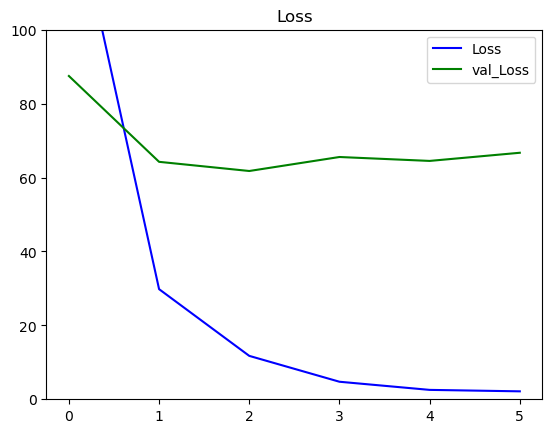

In [29]:
import matplotlib.pyplot as plt
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=100.0)


Indeed, the loss went close to 0 very fast, but the validation loss, in our case, is kind of converged on the 70s,
so it was correct, early stopping made the right call.

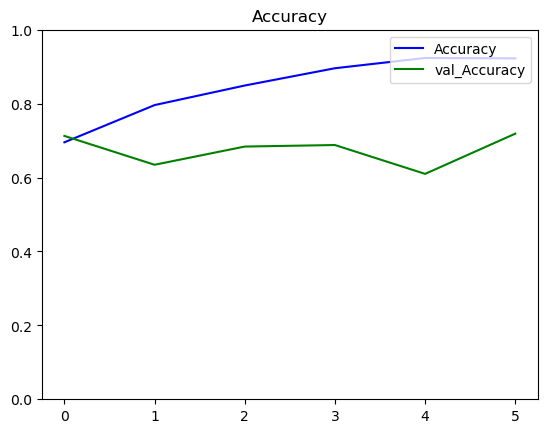

In [30]:
plot_metrics(history.history['accuracy'], history.history['val_accuracy'], "Accuracy", "Accuracy", ylim=1.0)


We can see that effectively accuracy is around 70%. It doesn't improve over time. Of course, the training accuracy,
it does.

## Some manual validation

In the manual validation, we will construct the same way as before the test input with the review horrible restaurant.
And we pass it via the model checking.

In [50]:
# So first, we will extend it. We will have our test point, which needs to be of shape (1,933)
test_point = np.zeros((1, max_review_length))
tokenized_review = tokenizer.texts_to_sequences(['I am ill.'])[0]
tokenized_review.extend([0] * (max_review_length -3))
# tokenized_review = tokenizer.texts_to_sequences(['Horrible restaurant'])[0]
# tokenized_review.extend([0] * (max_review_length -2))
test_point = np.array([tokenized_review])
test_point.shape

(1, 933)

In [51]:
# We run model.predict being less than 0.5, and we indeed get true. So the model correctly
# predicted that horrible restaurant is bad.
predicted_value = model.predict(tf.constant(test_point))
predicted_value

1/1 [==============================] - 0s 16ms/step


array([[0.05244273]], dtype=float32)

In [33]:
predicted_value < 0.5

array([[False]])

Now we will get a random. So let's get a random from the test set - a random review.
We will use this tokenizer.sequences_to_texts to tokenize it correctly.

In [52]:
i = np.random.randint(0, X_test_tensor.shape[0])
tokenizer.sequences_to_texts([X_test_tensor[i].numpy()])

["well what can i say about this place the restaurant is located in an upscale commercial complex with boutiques and an aj 's in the middle of arrowhead ranch definitely does n't have the boring suburban feel which you get along bell road only a mile away the inside has exposed brick on the walls with sleek looking seating each food item comes out looking like a self made creation from the chef i have to say the marguerite pizza is one of my favorites having a crispy crust and savory flavors that make my mouth want to eat more more and more but i do n't need to eat more because i fill my mouth with a good wine i had a dutton estate chardonnay i think which was half off on this day which kept me happy this place did not fail me so will i be back umm that 's a yes"]

In [53]:
prediction = model.predict(np.array([X_test_tensor[i]])) > 0.5
prediction == y_test_tensor[i]

1/1 [==============================] - 0s 44ms/step


<tf.Tensor: shape=(1, 1), dtype=bool, numpy=array([[ True]])>

What you should do eventually is a model.evaluate on the test set and on the labels on the test set to get all your metrics.

In [54]:
model.evaluate(X_test_tensor, y_test_tensor)

51/51 [==============================] - 0s 982us/step - loss: 58.0754 - accuracy: 0.7394 - precision: 0.8169 - recall: 0.8768


[58.07537078857422, 0.7393715381622314, 0.8169013857841492, 0.8767951726913452]

Therefore, the model predicts correctly 70% of the reviews, but with 80% precision and recall, so we have a good distribution between positives and negatives.
That is our baseline, let's see if we can improve it on future demos.

Notice, before ending this demo, <span style="background:yellow">the most important thing that we have done is that conversion from a dataset raw text into the input tensor.</span>